In [74]:
import os
from itertools import combinations

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyro
import seaborn as sns
import torch
from math import ceil, floor
import functools
import dill
import sys

import bayes_air.utils.dataloader as ba_dataloader
from bayes_air.model import augmented_air_traffic_network_model_simplified
from bayes_air.network import NetworkState, AugmentedNetworkState
from bayes_air.schedule import split_and_parse_full_schedule

from scripts.lga.lga_network import *

from tqdm.notebook import tqdm

plt.rcParams['font.size'] = 8
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['figure.dpi'] = 300

from pathlib import Path
dir_path = Path.cwd()



In [104]:
rng_seed = 1

pyro.clear_param_store()  # avoid leaking parameters across runs
pyro.enable_validation(True)
pyro.set_rng_seed(int(rng_seed))

day_strs_list = [['2019-07-04'], ['2019-07-10'], ['2019-07-18'], ['2019-07-15']]
network_airport_codes = ['LGA']
dt = .1

device = torch.device("cpu")

# Hyperparameters
initial_aircraft = 50.0 # not used!
mst_effective_hrs = 24 # not used!
mst_split = 1 # not really used

subsamples = {}

for day_strs in day_strs_list:
    # gather data
    days = pd.to_datetime(day_strs)
    data = ba_dataloader.load_remapped_data_bts(days)
    name = day_strs[0]

    num_days = len(days)
    num_flights = sum([len(df) for df in data.values()])

    # make things with the data
    travel_times_dict, observations_df = \
        make_travel_times_dict_and_observation_df(
            data, network_airport_codes
        ) 
    states = make_states(data, network_airport_codes)

    model = functools.partial(
        augmented_air_traffic_network_model_simplified,

        travel_times_dict=travel_times_dict,
        initial_aircraft=initial_aircraft,

        include_cancellations=False,
        mean_service_time_effective_hrs=mst_effective_hrs,
        delta_t=dt,

        source_use_actual_departure_time=True,
        source_use_actual_cancelled=False,
    )

    subsamples[name] = {
        "model": model,
        "states": states,
        "travel_times_dict": travel_times_dict,
        "observations_df": observations_df,
    }

print(subsamples.keys())

dict_keys(['2019-07-04', '2019-07-10', '2019-07-18', '2019-07-15'])


In [4]:
def get_samples_df(name, mst, n):
    sdd = pd.DataFrame()
    add = None
    for i in tqdm(range(n)):
        posterior_samples = {
            'LGA_0_mean_service_time': torch.tensor([mst]).to(device)
        }
        s = subsamples[name]
        model, states, observations_df = s["model"], s["states"], s["observations_df"]
        hourly_delays = get_hourly_delays_from_z_sample(model, posterior_samples, states, observations_df)
        sdd[i] = hourly_delays.sample_departure_delay
        if i == 0:
            add = hourly_delays.actual_departure_delay
    return sdd, add


In [5]:
sdd_a, add_a = get_samples_df('2019-07-04', .020, 20)
display(sdd_a)
display(add_a)

  0%|          | 0/20 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
5,0.033499,0.000000,0.016220,0.007139,0.054727,0.021846,0.055196,0.009992,0.020993,0.040233,0.040065,0.023112,0.007170,0.001875,0.023224,0.017992,0.044367,0.025642,0.000331,0.003518
6,0.068092,0.053140,0.058304,0.055600,0.062313,0.065105,0.105967,0.079798,0.036627,0.074704,0.073958,0.098147,0.070891,0.092092,0.075598,0.152344,0.077680,0.110919,0.061977,0.085515
7,0.090531,0.065486,0.076017,0.097066,0.116274,0.066734,0.067408,0.136226,0.100917,0.062935,0.078906,0.063234,0.090195,0.078656,0.072428,0.048411,0.110013,0.103360,0.085508,0.062543
8,0.141435,0.178417,0.159979,0.124842,0.181880,0.205044,0.121916,0.162955,0.160572,0.199545,0.288435,0.112534,0.171860,0.153455,0.244343,0.154456,0.166987,0.147756,0.128636,0.119577
9,0.177716,0.259278,0.213513,0.252684,0.278582,0.347924,0.203207,0.286033,0.242396,0.228345,0.266403,0.262206,0.588342,0.284482,0.357664,0.252478,0.390524,0.298779,0.274791,0.291143
10,0.209252,0.432037,0.458875,0.562129,0.479910,0.799677,0.481105,0.571748,0.544426,0.423995,0.302037,0.536143,0.735254,0.514590,0.685015,0.522108,0.595711,0.489538,0.536122,0.555345
11,0.354361,0.447661,0.500798,0.657431,0.466012,0.904251,0.432045,0.578632,0.506292,0.504042,0.496000,0.551551,0.652137,0.595264,0.724948,0.564419,0.619702,0.443730,0.800006,0.500353
12,0.464738,0.516526,0.607501,0.859087,0.458248,0.920899,0.465905,0.555867,0.606266,0.527124,0.488367,0.518059,0.489173,0.704415,0.908547,0.719765,0.500409,0.463374,0.831641,0.500349
13,0.536838,0.326517,0.650318,1.085806,0.475334,0.874680,0.400723,0.489587,0.649351,0.381603,0.588132,0.406965,0.762372,0.442603,0.863967,0.734377,0.571552,0.537275,0.896586,0.424461
14,0.376922,0.264634,0.408547,0.966313,0.401876,0.681222,0.444175,0.495236,0.573153,0.233364,0.410959,0.345245,0.642561,0.397677,0.596765,0.615371,0.587934,0.287754,0.678210,0.355610


5     0.031250
6     0.003333
7     0.066667
8     0.003086
9     0.032353
10    0.137333
11    0.136806
12    0.058333
13    0.006667
14    0.068421
15    0.137302
16    0.004444
17    0.039394
18    0.148611
19    0.816667
20    0.466667
21    0.277778
22    0.000000
Name: actual_departure_delay, dtype: float64

In [96]:
def plot_delays(sac_list, include_samples=False, figsize=(3.5,3.5), ylimupper=4.55, sim_msg='disrupted'):
    fig, ax = plt.subplots(figsize=figsize, dpi=300)
        
    ylim = (-.05,ylimupper)
    xlim = (5,25)

    for name, sdd, add, c in sac_list:

        sm = sdd.mean(axis=1)
        sd = sdd.std(axis=1)
        # print(len(sm), len(sd))

        ax.plot(sm, f':{c}', linewidth=1.0, label=f'{name} ({sim_msg})')
        ax.fill_between(sdd.index, sm+sd, sm-sd, alpha=0.2, color=c)

        if include_samples:
            sdd.plot(ax=ax, legend=False, style=f'-{c}', alpha=.2)
        add.plot(ax=ax, legend=False, style=f'-{c}', alpha=1, label=f'{name} (actual)', linewidth=1.0)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.set_xlabel('Hour of day (LGA local time)', fontsize=8)
    ax.set_ylabel('Average hourly delay (hours)', fontsize=8)

    ax.legend(fontsize=6)

    ax.set_xticks(np.arange(6, 27, 3))
    
    return fig


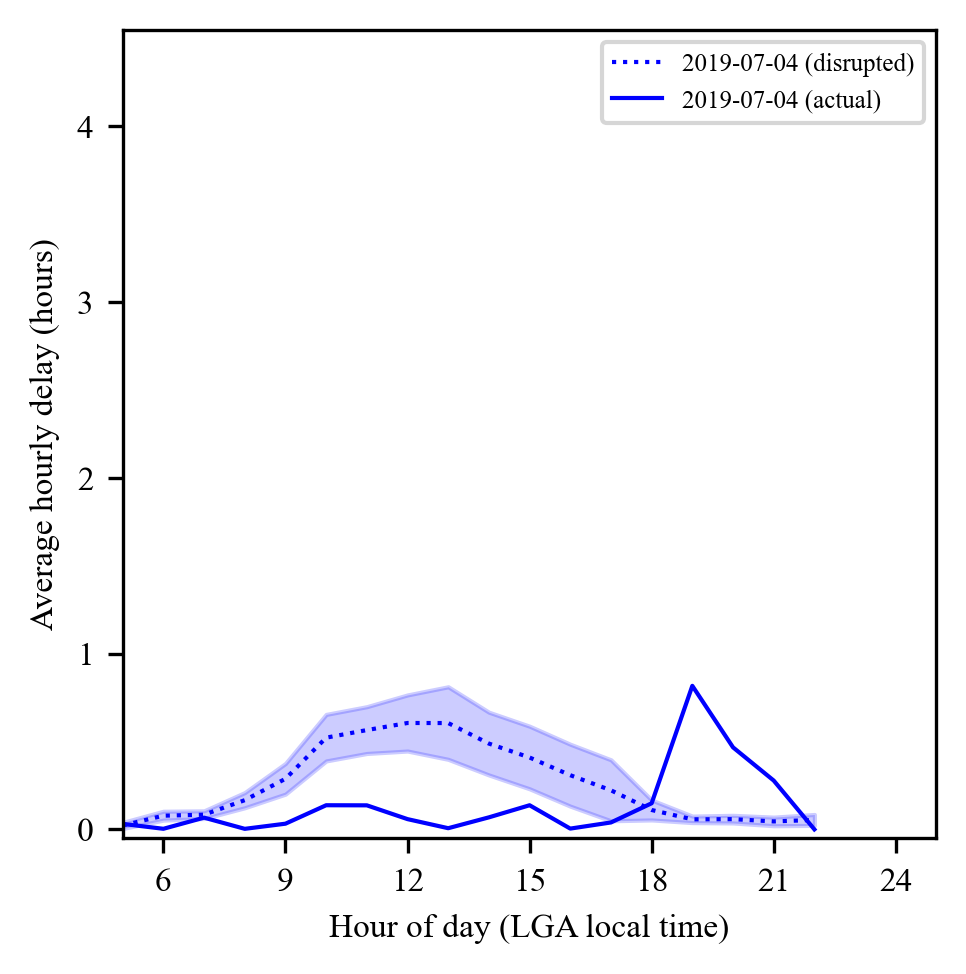

In [97]:
fig_a = plot_delays(
    [('2019-07-04', sdd_a, add_a, 'b')]
)

In [35]:
sdd_b, add_b = get_samples_df('2019-07-10', .020, 20)
display(sdd_b)
print(add_b)

  0%|          | 0/20 [00:00<?, ?it/s]

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x105eaea40>>
Traceback (most recent call last):
  File "/Users/jzha/Library/Caches/pypoetry/virtualenvs/bayes-air-LsmgEu8U-py3.10/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
5,0.015266,0.026576,0.034090,0.018833,0.011126,0.026858,0.063344,0.002444,0.070039,0.064610,0.021020,0.001230,0.020446,0.023014,0.050445,0.011270,0.039997,0.017625,0.008977,0.004947
6,0.151434,0.187670,0.141870,0.179925,0.145015,0.122786,0.224587,0.200263,0.135687,0.182960,0.324986,0.205038,0.242307,0.156334,0.152288,0.178437,0.108340,0.143935,0.242225,0.193706
7,0.209359,0.215066,0.148375,0.099217,0.263966,0.147761,0.102834,0.114387,0.072349,0.138802,0.172198,0.096501,0.080475,0.172419,0.079575,0.128420,0.097410,0.206450,0.127539,0.098497
8,0.546516,0.544990,0.316374,0.302701,0.385726,0.292950,0.460703,0.349556,0.350577,0.314234,0.585646,0.388363,0.382086,0.361592,0.470093,0.240477,0.413787,0.616537,0.422646,0.341303
9,0.812634,0.823339,0.545757,0.776213,0.683887,0.766562,0.842477,0.744051,0.680035,0.548579,0.800507,0.747542,0.776020,0.614781,0.747550,0.709321,0.738629,1.135087,0.791084,0.774576
10,1.020456,0.981181,0.909866,0.992491,0.859361,1.271294,1.268650,0.924458,0.835472,0.861463,1.184477,1.076795,1.216604,1.015382,1.174468,0.989494,1.038880,1.403899,1.104238,1.130913
11,1.239535,1.265857,1.169268,1.337590,1.290178,1.495694,1.524008,1.168826,1.255021,1.173720,1.648780,1.375301,1.686882,1.198486,1.368203,1.291841,1.415807,1.803816,1.492897,1.543347
12,1.583249,1.399607,1.467963,1.348344,1.688993,1.842875,1.787388,1.295457,1.534407,1.403419,2.127271,1.670780,1.861276,1.412932,1.391853,1.584624,1.827056,2.113398,1.684422,1.834417
13,1.740464,1.517666,1.729437,1.381312,1.800829,2.307138,2.120739,1.583667,1.805597,1.620422,2.492674,1.809433,2.225478,1.712484,1.727239,1.857396,1.988998,2.440223,1.957263,2.210556
14,1.874991,1.681811,1.950311,1.505138,2.088407,2.272803,2.263928,1.709721,1.926753,1.713675,2.557509,1.962655,2.277412,1.916994,1.689735,2.003948,2.228326,2.711294,1.979720,2.394712


5     0.000000
6     0.007812
7     0.039103
8     0.016260
9     0.216239
10    0.086905
11    0.222778
12    0.116162
13    0.283889
14    0.157658
15    0.131818
16    0.266667
17    0.211429
18    0.194872
19    0.163793
20    0.182184
21    0.187500
22    0.388889
23    0.250000
24         NaN
25         NaN
Name: actual_departure_delay, dtype: float64


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


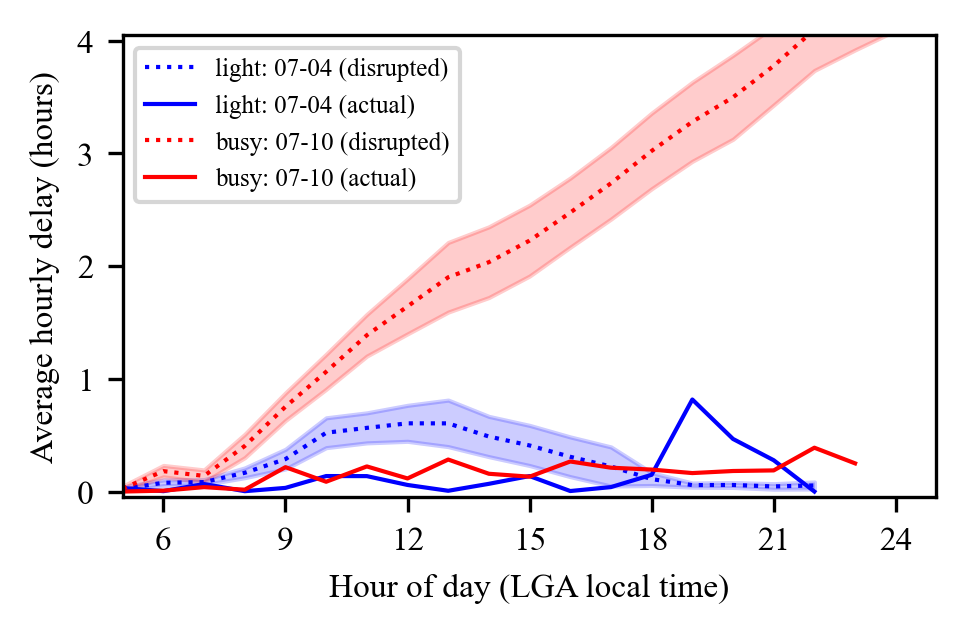

In [98]:
fig_ab = plot_delays(
    [
        ('light: 07-04', sdd_a, add_a, 'b'), 
        ('busy: 07-10', sdd_b, add_b, 'r')
    ],
    ylimupper=4.05,
    figsize=(3.5,2.0)
)

for ext in ('png', 'eps', 'pdf'):
    plt.savefig(f'paper_plots/busy_light_comparison.{ext}', bbox_inches='tight', pad_inches=0)

sdd_a.to_csv(dir_path / 'plotting_data_cache/sdd_a.csv')
add_a.to_csv(dir_path / 'plotting_data_cache/add_a.csv')
sdd_b.to_csv(dir_path / 'plotting_data_cache/sdd_b.csv')
add_b.to_csv(dir_path / 'plotting_data_cache/add_b.csv')

In [101]:
from pathlib import Path

dir_path = Path.cwd()

# /bayes-air-atrds-attempt-8/checkpoints/nsf_730
ckpt_path = dir_path / 'bayes-air-atrds-attempt-8/final/nsf_730/final/output_dict.pkl'

with open(ckpt_path, 'rb') as f:
    output_dict = dill.load(f)

guide = output_dict['guide']


from scripts.lga.lga_training import WeatherThreshold, ClusterThreshold

wt = WeatherThreshold(50., device, 0., 0.)
ct = ClusterThreshold(50., device, 0., 0.) # dummy init

wt.load_state_dict(output_dict['wt_state_dict'])
ct.load_state_dict(output_dict['ct_state_dict'])

extras_path = dir_path / 'extras'

processed_visibility = pd.read_csv(extras_path / 'processed_visibility.csv')
visibility_dict = dict(processed_visibility.values)
processed_ceiling = pd.read_csv(extras_path / 'processed_ceiling.csv')
ceiling_dict = dict(processed_ceiling.values)

processed_x = pd.read_csv(extras_path / 'x_capacity_counts.csv') # TODO: option
x_dict = dict(processed_x.values)
processed_y = pd.read_csv(extras_path / 'y_event_delays.csv') # TODO: option
y_dict = dict(processed_y.values)

y_threshold = output_dict["y_th"]
x_threshold = output_dict["x_th"]



In [90]:
name = '2019-07-18'

def get_label(name):
    y = y_dict[name]
    x = x_dict[name]
    y_label = 1.0 if y > y_threshold else 0.0
    x_label = 1.0 if x > x_threshold else 0.0
    y_label = torch.tensor([y_label])
    x_label = torch.tensor([x_label])

    label = ct.assign_label(y_label, x_label, visibility_dict[name], ceiling_dict[name])
    # print(label)
    return label

def transform_sample(sample):
    return .004 * sample + .02

c_label = get_label(name)

print(transform_sample(guide(c_label).sample((10,))))

tensor([[0.0158],
        [0.0168],
        [0.0153],
        [0.0167],
        [0.0168],
        [0.0137],
        [0.0176],
        [0.0137],
        [0.0181],
        [0.0148]])


In [79]:
def get_samples_df_using_guide(name, guide, label, n):
    sdd = pd.DataFrame()
    add = None
    samples = transform_sample(guide(label).sample((n,)))
    for i in tqdm(range(n)):
        posterior_samples = {
            'LGA_0_mean_service_time': samples[i]
        }
        s = subsamples[name]
        model, states, observations_df = s["model"], s["states"], s["observations_df"]
        hourly_delays = get_hourly_delays_from_z_sample(model, posterior_samples, states, observations_df)
        sdd[i] = hourly_delays.sample_departure_delay
        if i == 0:
            add = hourly_delays.actual_departure_delay
    return sdd, add

In [ ]:
sdd_c, add_c = get_samples_df_using_guide('2019-07-18', guide, c_label, 20)
display(sdd_c)
display(add_c)

  0%|          | 0/20 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
5,0.033293,0.035258,0.024138,0.061146,0.031190,0.005147,0.043686,0.050175,0.020606,0.015115,0.004128,0.033456,0.016535,0.018814,0.004578,0.028243,0.046003,0.011510,0.014090,0.012639
6,0.117789,0.081746,0.095526,0.146557,0.085834,0.115343,0.116083,0.098999,0.186242,0.112483,0.202818,0.077372,0.087210,0.104849,0.101774,0.080703,0.106671,0.210900,0.108641,0.092322
7,0.048734,0.099690,0.114986,0.084050,0.072374,0.074509,0.151856,0.127024,0.106977,0.085127,0.100773,0.093301,0.077758,0.109387,0.093676,0.088297,0.072489,0.099724,0.069357,0.102000
8,0.169219,0.183688,0.249623,0.293747,0.189010,0.270510,0.277936,0.328743,0.357328,0.351254,0.345947,0.363922,0.219649,0.373704,0.227373,0.283218,0.256940,0.378809,0.370432,0.314425
9,0.297650,0.393622,0.310322,0.353254,0.297649,0.417034,0.391422,0.546988,0.665126,0.620014,0.684402,0.585481,0.447462,0.630951,0.249836,0.535885,0.410196,0.795173,0.500625,0.608789
10,0.483737,0.533177,0.510342,0.554816,0.455488,0.623678,0.563846,0.858700,0.835706,1.021109,0.877142,0.714546,0.604924,0.927598,0.442169,0.798095,0.686439,1.040597,0.890760,0.767683
11,0.632357,0.451586,0.496521,0.654589,0.466999,0.717452,0.656671,1.100123,0.894253,1.095696,1.189711,0.726786,0.609383,1.200303,0.463936,1.164940,0.749082,1.395631,1.185693,0.815094
12,0.644259,0.396767,0.435911,0.714322,0.366771,0.493232,0.605415,1.257919,0.841965,1.021727,1.277211,0.677495,0.548722,1.133482,0.444196,1.260860,0.560193,1.629995,1.206606,0.778535
13,0.554218,0.397531,0.355970,0.842085,0.382199,0.562317,0.791964,1.185763,0.921315,1.061249,1.160961,0.568297,0.555884,1.251266,0.502622,1.339203,0.705341,1.579029,1.137675,0.975120
14,0.594327,0.395343,0.343004,0.756717,0.587451,0.601426,1.029766,1.182806,1.058706,1.211658,1.125605,0.453629,0.543251,1.414684,0.466773,1.551233,0.754342,1.635496,1.137193,1.078741


5     0.000000
6     0.063441
7     0.234259
8     0.258065
9     0.176667
10    0.555556
11    0.843750
12    0.507222
13    0.526190
14    0.758081
15    0.339655
16    0.806944
17    0.611111
18    1.050725
19    1.138194
20    1.600595
21    1.853125
22    1.894737
23    2.530769
24    3.438889
Name: actual_departure_delay, dtype: float64

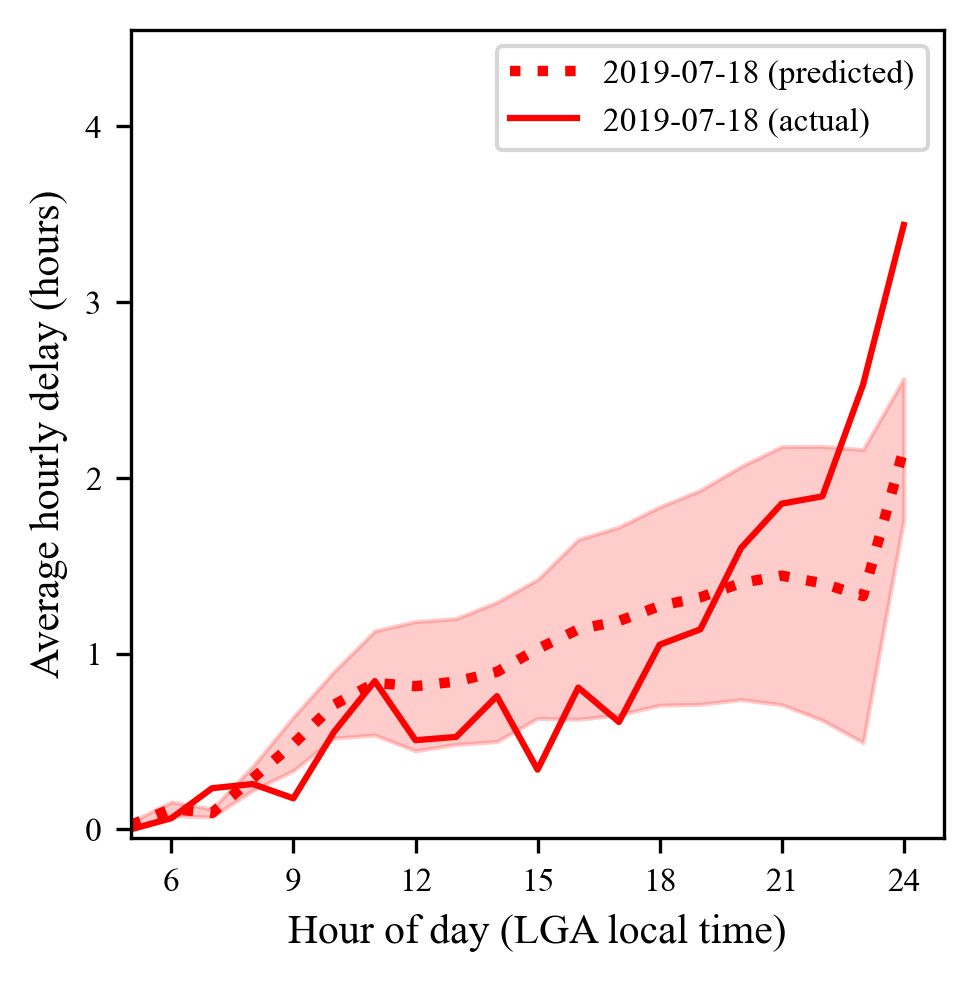

In [89]:
name = '2019-07-18'

fig_a = plot_delays(
    [(name, sdd_c, add_c, 'r')],
    sim_msg='predicted',
)

sdd_c.to_csv(dir_path / f'plotting_data_cache/sdd_c_{name}.csv')
add_c.to_csv(dir_path / f'plotting_data_cache/add_c_{name}.csv')


In [105]:
d_name = '2019-07-15'

d_label = get_label(d_name)
sdd_d, add_d = get_samples_df_using_guide(d_name, guide, d_label, 20)
display(sdd_d)
display(add_d)

  0%|          | 0/20 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
5,0.004851,0.000500,0.023018,0.007737,0.007049,0.010578,0.020372,0.020055,0.000000,0.000000,0.001582,0.035744,0.004132,0.024932,0.005251,0.006031,0.021591,0.000940,0.022510,0.011924
6,0.066336,0.063613,0.080341,0.078916,0.081882,0.084872,0.063878,0.077055,0.140134,0.082278,0.190937,0.095475,0.074465,0.074190,0.096347,0.061524,0.063223,0.079234,0.070455,0.093208
7,0.058038,0.064604,0.056889,0.072106,0.071048,0.056393,0.077142,0.103362,0.072925,0.062525,0.067055,0.056979,0.058913,0.063971,0.060930,0.081509,0.083652,0.079482,0.075334,0.089710
8,0.103700,0.145576,0.118781,0.092932,0.233778,0.153237,0.122024,0.182444,0.150132,0.146299,0.162902,0.157739,0.111207,0.137281,0.131068,0.164829,0.170499,0.182371,0.248668,0.250739
9,0.078410,0.090007,0.144662,0.088547,0.233704,0.178106,0.141537,0.287644,0.148097,0.151967,0.274161,0.086600,0.151333,0.143975,0.099392,0.192053,0.267846,0.249741,0.190609,0.388791
10,0.151233,0.079605,0.119617,0.068743,0.208220,0.371080,0.112579,0.238780,0.059880,0.192028,0.461311,0.144079,0.239817,0.095488,0.117687,0.196282,0.133087,0.313078,0.321422,0.391984
11,0.097521,0.090314,0.116500,0.073519,0.209079,0.263758,0.088262,0.199914,0.099986,0.210207,0.468548,0.072362,0.145286,0.146057,0.056780,0.129601,0.182639,0.150836,0.237459,0.334766
12,0.089535,0.113873,0.118344,0.086055,0.242966,0.250195,0.078154,0.155532,0.136610,0.125182,0.649608,0.172041,0.131323,0.189350,0.113383,0.129756,0.227315,0.111040,0.109097,0.408550
13,0.072769,0.098710,0.069199,0.174044,0.157067,0.182039,0.085182,0.198023,0.170499,0.112686,0.725816,0.078952,0.109424,0.186896,0.077805,0.097424,0.157295,0.102678,0.187239,0.334952
14,0.103056,0.103110,0.104147,0.131992,0.237887,0.136836,0.264615,0.179380,0.280665,0.115632,0.510368,0.120959,0.143243,0.251737,0.082635,0.118489,0.258306,0.230748,0.265637,0.215050


5     0.000000
6     0.021505
7     0.013095
8     0.025641
9     0.135000
10    0.014943
11    0.217816
12    0.090909
13    0.071839
14    0.106667
15    0.061111
16    0.103125
17    0.043434
18    0.202778
19    0.502020
20    0.069872
21    0.361333
22    0.681250
Name: actual_departure_delay, dtype: float64

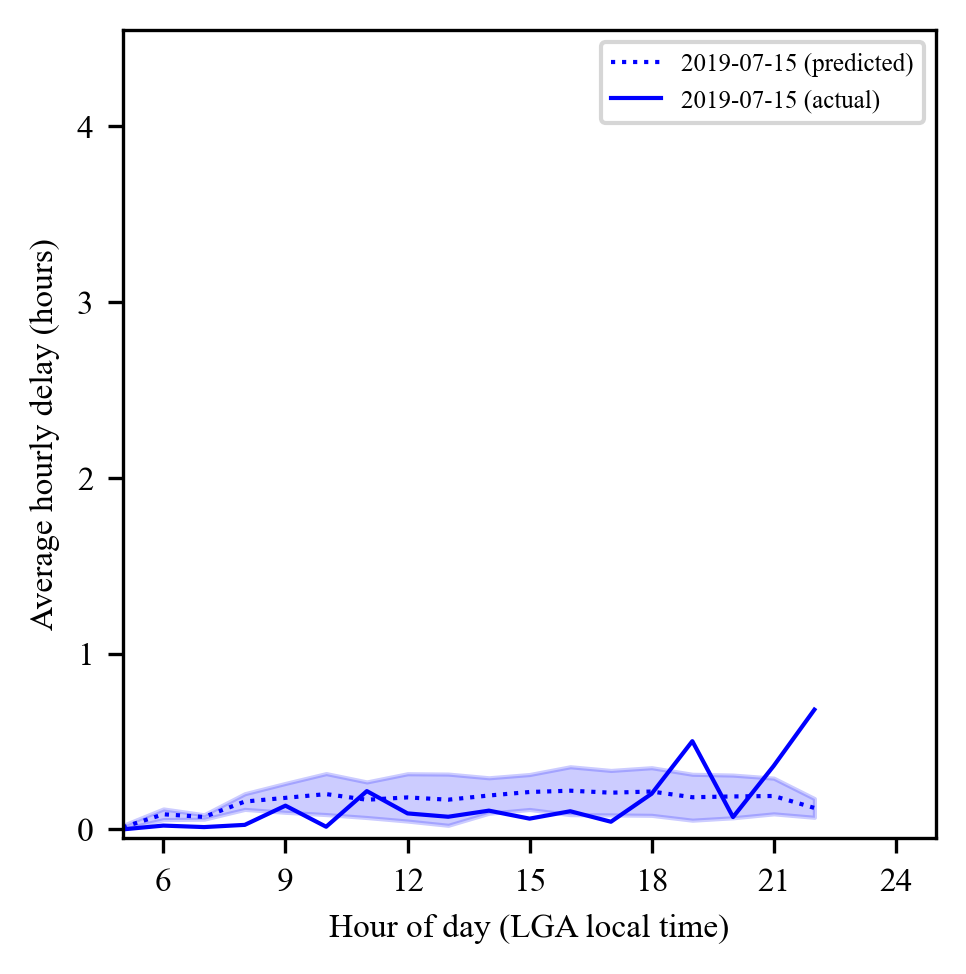

In [106]:
fig = plot_delays(
    [(name, sdd_d, add_d, 'b')],
    sim_msg='predicted',
)

sdd_d.to_csv(dir_path / f'plotting_data_cache/sdd_d_{d_name}.csv')
add_d.to_csv(dir_path / f'plotting_data_cache/add_d_{d_name}.csv')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


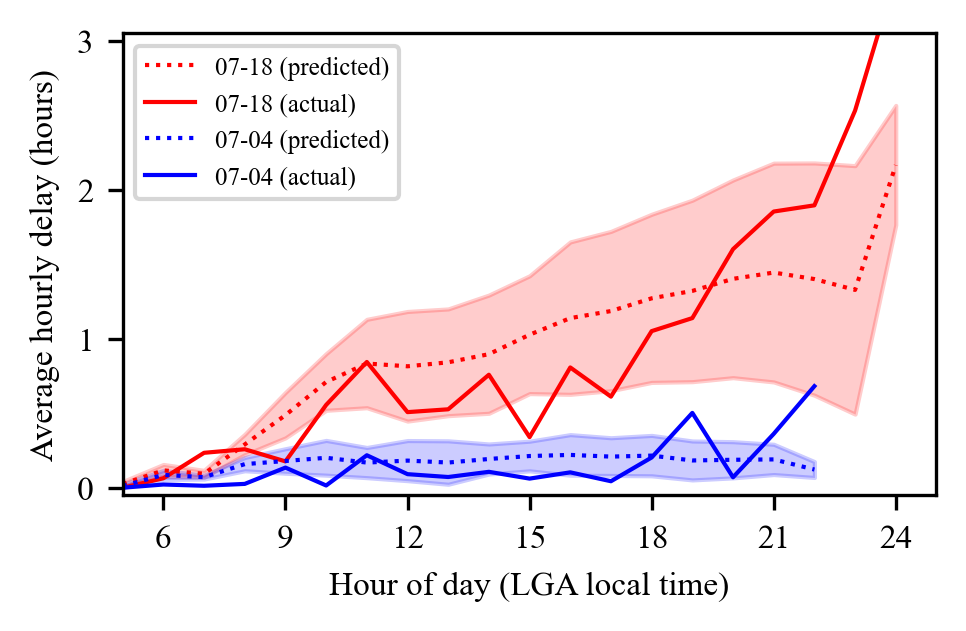

In [109]:
fig_cd = plot_delays(
    [
        ('07-18', sdd_c, add_c, 'r'), 
        ('07-04', sdd_d, add_d, 'b')
    ],
    sim_msg='predicted',
    ylimupper=3.05,
    figsize=(3.5,2.0)
)

for ext in ('png', 'eps', 'pdf'):
    plt.savefig(f'paper_plots/posterior_predictive_comparison.{ext}', bbox_inches='tight', pad_inches=0)